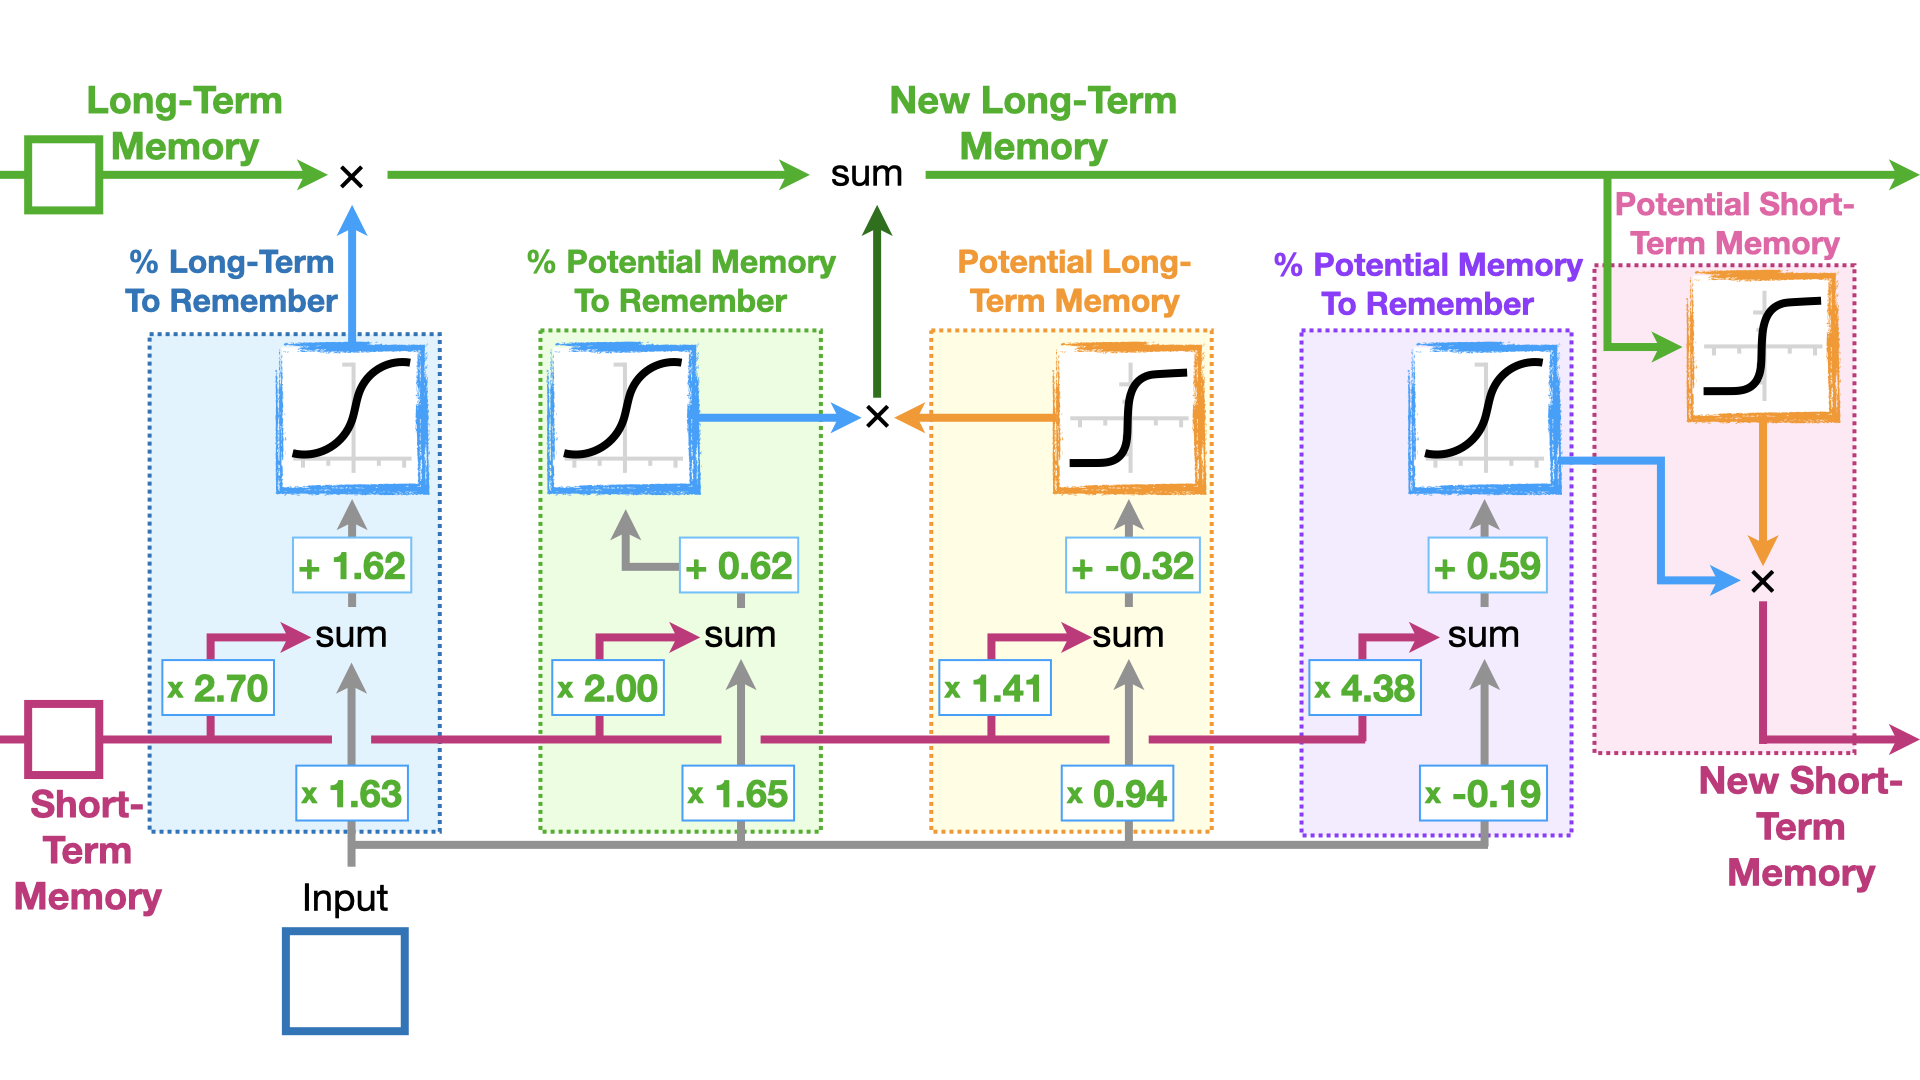

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## LSTM by Hand

In [4]:
class LSTMbyHand(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        
        mean = torch.tensor(0.0)
        std = torch.tensor(0.1)

        ## forget gate
        self.Wf = nn.Parameter(torch.normal(mean=mean, std=std, size=(hidden_size, input_size)), requires_grad=True)
        self.Uf = nn.Parameter(torch.normal(mean=mean, std=std, size=(hidden_size, hidden_size)), requires_grad=True)
        self.bf = nn.Parameter(torch.zeros(hidden_size), requires_grad=True)

        ## input gate
        self.Wi = nn.Parameter(torch.normal(mean=mean, std=std, size=(hidden_size, input_size)), requires_grad=True)
        self.Ui = nn.Parameter(torch.normal(mean=mean, std=std, size=(hidden_size, hidden_size)), requires_grad=True)
        self.bi = nn.Parameter(torch.zeros(hidden_size), requires_grad=True)

        ## State gate
        self.Ws = nn.Parameter(torch.normal(mean=mean, std=std, size=(hidden_size, input_size)), requires_grad=True)
        self.Us = nn.Parameter(torch.normal(mean=mean, std=std, size=(hidden_size, hidden_size)), requires_grad=True)
        self.bs = nn.Parameter(torch.zeros(hidden_size), requires_grad=True)

        ## Output gate
        self.Wo = nn.Parameter(torch.normal(mean=mean, std=std, size=(hidden_size, input_size)), requires_grad=True)
        self.Uo = nn.Parameter(torch.normal(mean=mean, std=std, size=(hidden_size, hidden_size)), requires_grad=True)
        self.bo = nn.Parameter(torch.zeros(hidden_size), requires_grad=True)

        self.hidden_size = hidden_size

    def forward(self, input, hidden, cell_state):
        forget_gate = torch.sigmoid(torch.matmul(self.Wf, input) + torch.matmul(self.Uf, hidden) + self.bf)
        input_gate = torch.sigmoid(torch.matmul(self.Wi, input) + torch.matmul(self.Ui, hidden) + self.bi)
        state_gate = torch.tanh(torch.matmul(self.Ws, input) + torch.matmul(self.Us, hidden) + self.bs)
        output_gate = torch.sigmoid(torch.matmul(self.Wo, input) + torch.matmul(self.Uo, hidden) + self.bo)

        cell_state = forget_gate * cell_state + input_gate * state_gate
        hidden = output_gate * torch.tanh(cell_state)

        return hidden, cell_state

    def optimize(self):
        return optim.Adam(self.parameters(), lr=0.001)

    def train_model(self, batches, max_epoch=10000):
        optimizer = self.optimize()
        i = 0
        for epoch in range(max_epoch):
            hidden = torch.zeros(self.hidden_size)
            cell_state = torch.zeros(self.hidden_size)
            
            for index in range(len(batches)):
                input = batches[index][:4].view(-1, 1)  # Extract input and reshape to (4, 1)
                target = batches[index][4].unsqueeze(0)  # Extract target value
                
                hidden, cell_state = self.forward(input, hidden, cell_state)
                loss = torch.mean((hidden - target) ** 2)
                
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                
                # Detach hidden and cell state to prevent the graph from growing
                hidden = hidden.detach()
                cell_state = cell_state.detach()
                i+=1
                if(i%100 == 0):
                    print(f'Epoch {epoch} Loss {loss.item()}')

    def predict(self, input):
        hidden = torch.zeros(self.hidden_size)
        cell_state = torch.zeros(self.hidden_size)
        hidden, cell_state = self.forward(input, hidden, cell_state)
        return hidden
    def evaluate(self, input):
        hidden = torch.zeros(self.hidden_size)
        cell_state = torch.zeros(self.hidden_size)
        hidden, cell_state = self.forward(input, hidden, cell_state)
        return hidden/input[-1] * 100

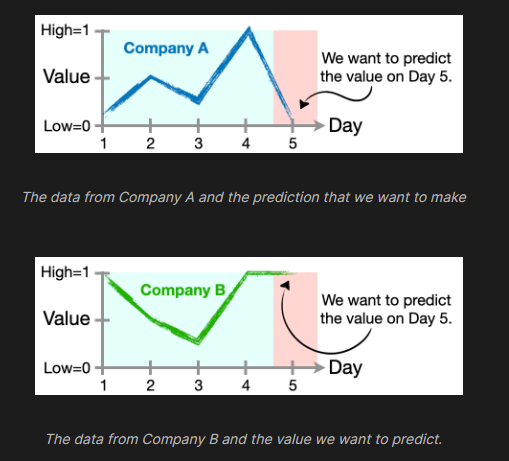

In [5]:
def dataLoader():
    batches = torch.tensor([[0.0, 0.5, 0.25, 1.0, 0.0], [1.0, 0.5, 0.25, 1.0, 1.0]])
    return batches

In [6]:
input_size = 4  
hidden_size = 1
lstm = LSTMbyHand(input_size, hidden_size)
# Load the data
batches = dataLoader()
# Train the model
lstm.train_model(batches,max_epoch=10000)


Epoch 49 Loss 0.7642434239387512
Epoch 99 Loss 0.5080241560935974
Epoch 149 Loss 0.3376654088497162
Epoch 199 Loss 0.24680165946483612
Epoch 249 Loss 0.1985481232404709
Epoch 299 Loss 0.17203593254089355
Epoch 349 Loss 0.15725846588611603
Epoch 399 Loss 0.149086132645607
Epoch 449 Loss 0.14455555379390717
Epoch 499 Loss 0.1418028473854065
Epoch 549 Loss 0.13967785239219666
Epoch 599 Loss 0.13756559789180756
Epoch 649 Loss 0.13521826267242432
Epoch 699 Loss 0.13259002566337585
Epoch 749 Loss 0.129718616604805
Epoch 799 Loss 0.1266663670539856
Epoch 849 Loss 0.12349676340818405
Epoch 899 Loss 0.12026868760585785
Epoch 949 Loss 0.11703405529260635
Epoch 999 Loss 0.11383663862943649
Epoch 1049 Loss 0.11071202903985977
Epoch 1099 Loss 0.10768721997737885
Epoch 1149 Loss 0.1047821193933487
Epoch 1199 Loss 0.10200954973697662
Epoch 1249 Loss 0.09937725216150284
Epoch 1299 Loss 0.09688830375671387
Epoch 1349 Loss 0.09454239904880524
Epoch 1399 Loss 0.09233681112527847
Epoch 1449 Loss 0.0902670

In [7]:
round(lstm.predict(torch.tensor([0.0, 0.5, 0.25, 1.0]))[0].item(),3)

-0.0

In [8]:
round(lstm.predict(torch.tensor([1.0, 0.5, 0.25, 1.0]))[0].item(),3)

0.762

In [12]:
lstm.evaluate(torch.tensor([1.0, 0.5, 0.25, 1.0]))[0].item()

76.15695190429688